### Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# global settings for pandas.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('mode.chained_assignment', None)

# global settings for seaborn.
sns.set_theme(style="whitegrid")

### Funciones auxiliares

In [3]:
def describe_df(cols: list, df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un índice {cols} y un DataFrame {df}, devuelve otro DataFrame con datos descriptivos
    según las medidas especificadas en el diccionario {measures}.
    """
    measures = {
        'Cardinality': df.nunique(), 
        'Null': df.shape[0] - df.count(), 
        '% Null': round((df.shape[0] - df.count()) / df.shape[0] * 100, 3),
        'Non-Null': df.count(), 
        '% Non-Null': round(df.count() / df.shape[0] * 100, 3), 
        'Types': df.dtypes,
        'Size (mb)': df.memory_usage() / 1000000
    }    
    return pd.DataFrame(index=cols, data=measures)

### Índice

[### Funciones auxiliares]

### Carga inicial de datos

In [4]:
o_data = pd.read_csv(filepath_or_buffer='properati.csv')

### Descripción del juego de datos original

Se utiliza la función `describe_df` que toma a una `list` de columnas y a un `DataFrame` como argumentos y devuelve un dataframe con algunas descripciones sobre los datos.

Esto permite conocer la cantidad de valores unívocos por columna, el peso de los nulos y sus tipos de dato correspondientes.

In [5]:
describe_df(cols=o_data.columns, df=o_data)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
Unnamed: 0,121220,0,0.000,121220,100.000,int64,0.96976
operation,1,0,0.000,121220,100.000,object,0.96976
property_type,4,0,0.000,121220,100.000,object,0.96976
place_name,1060,23,0.019,121197,99.981,object,0.96976
place_with_parent_names,1164,0,0.000,121220,100.000,object,0.96976
country_name,1,0,0.000,121220,100.000,object,0.96976
state_name,28,0,0.000,121220,100.000,object,0.96976
geonames_id,646,18717,15.441,102503,84.559,float64,0.96976
lat-lon,47203,51550,42.526,69670,57.474,object,0.96976
lat,46495,51550,42.526,69670,57.474,float64,0.96976


### Análisis de duplicados

El conjunto de datos, publicaciones de propiedades, corresponde al resultado de la ejecución de un web scrape o de un extracto de la base de datos de Properati. 

Siguiendo esta línea, el campo `properati_url` identifica a cada publicación y la presencia de valores duplicados en este campo, sería el indicador más claro de duplicidad.

Utilizando el método `duplicated` sobre el `DataFrame` e indicando como `subset` a la columna `properati_url` se puede evaluar lo anterior. 

In [6]:
o_data.duplicated(subset=['properati_url']).sum()

0

In [7]:
describe_df(o_data.columns, o_data).loc['properati_url']

Cardinality     121220
Null                 0
% Null               0
Non-Null        121220
% Non-Null         100
Types           object
Size (mb)      0.96976
Name: properati_url, dtype: object

No existen publicaciones duplicadas utilizando como identificador al vínculo de la publicación `properati_url` en la página de Properati.

### Análisis de dimensionalidad

Se evalúa removerer columnas que, a priori, no agregan valor para el análisis:

- **'Unnamed: 0'**: parece corresponder a un índice numérico.
- **'operation'**: se repite el mismo valor `sell` en todas las filas.
- **'place_with_parent_names'**: es una cadena de texto que concatena 'country_name', 'state_name' y 'place_name'.
- **'country_name'**: se repite el mismo valor `Argentina` en todas las filas.
- **'geonames_id'**: se debe buscar más información sobre este campo.
- **'lat-lon'**: se debe buscar más información sobre este campo.
- **'properati_url'**: vínculo a la publicación desde la que se obtuvieron y/o corresponden los datos.
- **'description'**: texto con datos adicionales sobre la publicación.
- **'title'**: título de la publicación.
- **'image_thumbnail'**: vínculo a la imagen miniatura de la publicación.

No obstante, para llegar a las conclusiones anteriores, las preguntas a responder fueron las siguientes:

- ¿Es el campo 'Unnamed: 0' simplemente una columna con un valor secuencial?
- ¿Es el campo 'operation' es relevante?
- ¿Es el campo 'place_with_parent_names' es relevante?
- ¿Es el campo 'country_name' es relevante?
- ¿Se pueden reducir los campos lat-lon, lat, lon y utilizar solo lat-lon?
- ¿Es el campo 'geonames_id' es relevante?
- ¿Existen datos adicionales dentro del título o de la descripción que sirvan para completar columnas faltantes?

#### Análisis de la variable: Unnamed: 0

##### ¿Es el campo 'Unnamed: 0' simplemente una columna con un valor secuencial?

In [8]:
describe_df(o_data.columns, o_data).loc['Unnamed: 0']

Cardinality     121220
Null                 0
% Null               0
Non-Null        121220
% Non-Null         100
Types            int64
Size (mb)      0.96976
Name: Unnamed: 0, dtype: object

In [9]:
o_data['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 121217, 121218, 121219], dtype=int64)

Si `Unnamed: 0` es un campo secuencial, sus elementos deberían ser iguales al `array` de `numpy` resultante de ejecutar el constructor `np.arange(0, total de filas)`.
El resultado de esto es un `array: Bool`.

In [10]:
o_data['Unnamed: 0'].values == np.arange(0, o_data.shape[0])

array([ True,  True,  True, ...,  True,  True,  True])

La suma de este array debe ser igual a la cantidad de filas en el `DataFrame` original, de esa manera, se puede concluir que el campo es un valor secuencial.

In [11]:
sum(o_data['Unnamed: 0'].values == np.arange(0, o_data.shape[0])) == o_data.shape[0]

True

#### Análisis de la variable: operation

##### ¿El campo 'operation' es relevante?

In [12]:
describe_df(o_data.columns, o_data).loc['operation']

Cardinality          1
Null                 0
% Null               0
Non-Null        121220
% Non-Null         100
Types           object
Size (mb)      0.96976
Name: operation, dtype: object

In [13]:
o_data['operation'].value_counts()

sell    121220
Name: operation, dtype: int64

El campo **operation** solamente repite el valor `sell` para cada observación.

#### Análisis de la variable: place_with_parent_names

##### ¿El campo 'place_with_parent_names' es relevante?

In [14]:
describe_df(o_data.columns, o_data).loc[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
place_with_parent_names,1164,0,0.000,121220,100.000,object,0.96976
country_name,1,0,0.000,121220,100.000,object,0.96976
state_name,28,0,0.000,121220,100.000,object,0.96976
place_name,1060,23,0.019,121197,99.981,object,0.96976


Se puede ver, a priori, que estos campos están completos en casi todos los registros. La única excepción es **place_name** que en solo 23 filas no hay datos.

Vale la pena analizar la hipótesis de si al concatenar **country_name**, **state_name** y **place_name** se puede llegar al mismo valor del campo **place_with_parent_names**.

Para esto, se visualizan los primeros valores de las columnas relevantes:

In [15]:
parent_names_subset = o_data[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]
parent_names_subset.head(5)

,place_with_parent_names,country_name,state_name,place_name
0,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,Mataderos
1,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,La Plata
2,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,Mataderos
3,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,Liniers
4,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,Centro


Dado que el separador es el caracter '|', se concatenan los valores de **country_name**, **state_name** y **place_name** y luego se verifica que este valor sea igual al de la columna **place_with_parent_names**. Por último, se filtran las filas donde la expresión calculada y la columna no coincidan.

In [16]:
# expresión.
parent_names_subset['expression'] = '|' + parent_names_subset.iloc[:,1] + '|' + parent_names_subset.iloc[:,2] + '|' + parent_names_subset.iloc[:,3] + '|'
# expresión != place_with_parent_names
parent_names_subset.loc[(parent_names_subset['expression'] != parent_names_subset['place_with_parent_names'])].head()

,place_with_parent_names,country_name,state_name,place_name,expression
4,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,Centro,|Argentina|Buenos Aires Costa Atlántica|Centro|
6,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Munro|
12,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|Martínez|
13,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo Soho,|Argentina|Capital Federal|Palermo Soho|
14,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo Soho,|Argentina|Capital Federal|Palermo Soho|


In [17]:
parent_names_subset.loc[(parent_names_subset['expression'] != parent_names_subset['place_with_parent_names'])].shape

(45220, 5)

Las filas donde la expresión difiere de la columna son 45.220 y vemos que, en algunos casos, hay más atributos de la ubicación dentro del campo **place_with_parent_names** y en otros simplemente es distinto. 

Este contexto adicional podría ser útil para agregar más precisión de manera categórica a la ubicación, aunque también podría evaluarse si permite completar los 23 valores nulos del campo **place_name**.

In [18]:
o_data[o_data['place_name'].isnull()].iloc[:,3:5]

,place_name,place_with_parent_names
6489,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
10201,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
11451,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
14839,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
18622,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
21922,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
23664,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
24722,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
38856,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
45970,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||


Aparentemente, los 23 valores faltantes para el campo **place_name** podemos obtenerlos del tercer valor concatenado dentro del campo **place_with_parent_names**.

In [19]:
o_data['place_name'] = o_data.apply(lambda x: x['place_with_parent_names'].split('|')[2] if x['place_name'] in (np.nan, None) else x['place_name'], axis=1)

Luego del apply anterior, los valores faltantes fueron introducidos y ya no quedan nulos.

In [20]:
describe_df(o_data.columns, o_data).loc[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
place_with_parent_names,1164,0,0.0,121220,100.0,object,0.96976
country_name,1,0,0.0,121220,100.0,object,0.96976
state_name,28,0,0.0,121220,100.0,object,0.96976
place_name,1060,0,0.0,121220,100.0,object,0.96976


#### Análisis de la variable: country_name

##### ¿Es relevante la variable country_name?

Luego de la función que cumplió el campo **country_name** en el paso anterior, la hipótesis es que su cardinalidad no aporta nada al análisis.

In [21]:
o_data['country_name'].value_counts()

Argentina    121220
Name: country_name, dtype: int64

In [22]:
describe_df(o_data.columns, o_data).loc['country_name']

Cardinality          1
Null                 0
% Null               0
Non-Null        121220
% Non-Null         100
Types           object
Size (mb)      0.96976
Name: country_name, dtype: object

Efectivamente, dado que solo tiene un valor y no registra nulos, podría ser excluido del juego de datos sin ningún impacto posterior.

#### Análisis de la variable: lat-lon

##### ¿Se puede reducir la cantidad de variables relacionadas: lat-lon, lat y lon?

La hipótesis es que el campo **lat-lon** puede reemplazar a los valores de los campos **lat** y **lon**, o bien, que ellos reemplacen al campo **lat-lon**.

El primer paso es crear un subset del DataFrame original con las columnas que nos interesan.

In [23]:
coordinates_subset = o_data[['lat-lon', 'lat', 'lon']]

Ahora evaluamos los siguientes escenarios:

- Cantidad de filas donde los valores de **lat-lon** son nulos y los valores de **lat** y **lon** también lo son (ie. `lat-long is null && lat is null & lon is null`)
  - Esto permitiría descartar a la columna **lat-lon** y trabajar con individualmente con sus componentes **lat** y **lon**.
- Coincidencia entre los valores en **lat-lon** y los valores en **lat** y **lon**.
  - Podría haber discrepancias entre estos campos o bien tener más precisión en alguno de ellos.

In [24]:
coordinates_mask = (coordinates_subset['lat-lon'].isnull()) & (coordinates_subset['lat'].isnull()) & (coordinates_subset['lon'].isnull())
describe_df(cols=coordinates_subset.columns, df=coordinates_subset.loc[coordinates_mask]).iloc[:,1:5]

,Null,% Null,Non-Null,% Non-Null
lat-lon,51550,100.0,0,0.0
lat,51550,100.0,0,0.0
lon,51550,100.0,0,0.0


In [25]:
describe_df(coordinates_subset.columns, coordinates_subset).iloc[:,1:5]

,Null,% Null,Non-Null,% Non-Null
lat-lon,51550,42.526,69670,57.474
lat,51550,42.526,69670,57.474
lon,51550,42.526,69670,57.474


Afortunadamente en todas las filas donde los valores de **lat-lon** son nulos, también lo son los valores de las columnas **lat** y **lon**.

Esto nos permitiría descartar a los valores de **lat-lon** siempre y cuando los mismos coincidan con aquellos que resultan de concatenar **lat** y **lon**.

A continuación probamos esta hipótesis, primero analizando la composición del campo conjunto de coordenadas y luego creando una expresión sintética para evaluar si son iguales:

In [26]:
coordinates_subset_not_null = coordinates_subset.loc[coordinates_subset['lat-lon'].isnull() == False]

In [27]:
coordinates_subset_not_null.head()

,lat-lon,lat,lon
0,"-34.6618237,-58.5088387",-34.661824,-58.508839
1,"-34.9038831,-57.9643295",-34.903883,-57.964330
2,"-34.6522615,-58.5229825",-34.652262,-58.522982
3,"-34.6477969,-58.5164244",-34.647797,-58.516424
4,"-38.0026256,-57.5494468",-38.002626,-57.549447


In [28]:
coordinates_subset_not_null.tail()

,lat-lon,lat,lon
121153,"-34.5992135511,-58.4025191971",-34.599214,-58.402519
121158,"-34.587425443,-58.3973722534",-34.587425,-58.397372
121160,"-34.563685346,-58.4426825896",-34.563685,-58.442683
121209,"-34.563685346,-58.4426825896",-34.563685,-58.442683
121217,"-34.5706388726,-58.4755963355",-34.570639,-58.475596


A priori se ve que los valores de **lat-lon** tienen algunos decimales más de precisión que los respectivos valores de los campos de **lat** y **lon**. Considerando una hipotética precisión adicional, podría ser útil reemplazar a los valores de los campos **lat** y **lon**.

Esto mismo se debe tener en cuenta al momento de hacer la comparación:

In [29]:
coordinates_subset_not_null['extracted_lat'] = coordinates_subset_not_null['lat-lon'].apply(lambda x: x.split(',')[0])
coordinates_subset_not_null['extracted_lon'] = coordinates_subset_not_null['lat-lon'].apply(lambda x: x.split(',')[1])

Comparamos hasta 3 decimales.

"The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus."

Source: https://stackoverflow.com/questions/1947481/how-many-significant-digits-should-i-store-in-my-database-for-a-gps-coordinate

In [30]:
coordinates_subset_not_null['extracted_lat'] = coordinates_subset_not_null['extracted_lat'].astype('float64')
coordinates_subset_not_null['extracted_lon'] = coordinates_subset_not_null['extracted_lon'].astype('float64')
coordinates_subset_not_null['lat'] = coordinates_subset_not_null['lat'].astype('float64')
coordinates_subset_not_null['lon'] = coordinates_subset_not_null['lon'].astype('float64')
coordinates_subset_not_null.shape

(69670, 5)

In [31]:
(coordinates_subset_not_null['extracted_lat'].apply(lambda x: round(x, 3)) == coordinates_subset_not_null['lat'].apply(lambda x: round(x, 3))).sum()

69670

In [32]:
(coordinates_subset_not_null['extracted_lon'].apply(lambda x: round(x, 3)) == coordinates_subset_not_null['lon'].apply(lambda x: round(x, 3))).sum()

69670

En el punto anterior logramos comprobar que los valores de los tres campos analizados coinciden entre sí hasta en un rango de 111 metros, en todos los casos.

Resulta una buena oportunidad apalancar la precisión adicional presente en el campo **lat-lon** para reemplazar a los valores existentes en **lat** y **lon** respectivamente.

Además, se podría desestimar el campo **lat-lon** ahora que fue desestructurado.

In [33]:
o_data['lat'] = o_data['lat-lon'].map(lambda x: x.split(',')[0] if isinstance(x, str) else np.nan)
o_data['lon'] = o_data['lat-lon'].map(lambda x: x.split(',')[1] if isinstance(x, str) else np.nan)
o_data['lat'] = o_data['lat'].astype('float64')
o_data['lon'] = o_data['lon'].astype('float64')
describe_df(o_data.columns, o_data).loc[['lat-lon', 'lon', 'lat']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat-lon,47203,51550,42.526,69670,57.474,object,0.96976
lon,46522,51550,42.526,69670,57.474,float64,0.96976
lat,46495,51550,42.526,69670,57.474,float64,0.96976


#### Análisis de la variable: geonames_id

##### ¿Es relevante el campo geonames_id?

La hipótesis es que el campo **geonames_id** hace referencia a la base de datos: https://www.geonames.org/

En este caso, podría ser útil evaluar si existen casos donde **geonames_id** pueda complementar a las columnas de **lat** y **lon**.

El primer paso es crear un subset del DataFrame original con las columnas que nos interesan.

In [34]:
geo_subset = o_data[['geonames_id', 'lat', 'lon']]

Ahora evaluamos los siguientes escenarios:

- Cantidad de filas donde **geonames_id** no es nulo pero los campos **lat** y **lon** sí lo son.
  - Para las filas donde esto suceda, **geonames_id** podría utilizarse para completarlas.

In [35]:
geo_subset_null_mask = (geo_subset['geonames_id'].isnull() == False) & (geo_subset['lat'].isnull()) & (geo_subset['lon'].isnull())
geo_subset_null = geo_subset[geo_subset_null_mask]
describe_df(geo_subset_null.columns, geo_subset_null)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
geonames_id,463,0,0.0,43365,100.0,float64,0.34692
lat,0,43365,100.0,0,0.0,float64,0.34692
lon,0,43365,100.0,0,0.0,float64,0.34692


El hecho de que para cada fila donde los valores de **lat** y **lon** son nulos exista un valor de **geonames_id**, permite la posibilidad de completar, por lo menos, algunos de los valores faltantes.

Para esto descargamos el dataset de Argentina disponible en la siguiente URL: https://download.geonames.org/export/dump/

In [36]:
geonames_columns = ['geonames_id', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country_code', 'cc2', 
                    'admin1_code', 'admin2_code', 'admin3_code', 'admin4 code', 'population', 'elevation', 'dem', 'timezone', 'modification date']

geonames_df = pd.read_csv('AR.txt', delimiter='\t', names=geonames_columns)
geonames_df.set_index('geonames_id', inplace=True)
geonames_df.head()

,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4 code,population,elevation,dem,timezone,modification date
geonames_id,,,,,,,,,,,,,,,,,,
3427200,Sierra del 15,Sierra del 15,NaN,-37.96613,-57.94670,T,HLL,AR,NaN,1.0,6357.0,NaN,NaN,0,NaN,200,America/Argentina/Buenos_Aires,2016-01-30
3427201,Puesto 1 Napoleón Cué,Puesto 1 Napoleon Cue,NaN,-28.63333,-56.11667,S,HSE,AR,NaN,6.0,18168.0,NaN,NaN,0,NaN,79,America/Argentina/Cordoba,2016-01-30
3427202,Cañada del Zorro,Canada del Zorro,NaN,-32.16667,-59.50000,H,STM,AR,NaN,8.0,NaN,NaN,NaN,0,NaN,65,America/Argentina/Cordoba,1993-12-21
3427203,Estancia Zorraquín,Estancia Zorraquin,NaN,-31.51553,-58.55208,S,RNCH,AR,NaN,8.0,30113.0,NaN,NaN,0,NaN,71,America/Argentina/Cordoba,2016-01-30
3427204,Estancia Zequeira Cué,Estancia Zequeira Cue,NaN,-28.43825,-56.08838,S,RNCH,AR,NaN,6.0,18168.0,NaN,NaN,0,NaN,98,America/Argentina/Cordoba,2016-01-30


Una vez cargado el conjunto de datos anterior, el paso siguiente es determinar los valores unívocos de **geonames_id** y hacer el mapeo de las columnas **lat** y **lon**.

In [37]:
geonames_lat_mapping_dict = { geo_id: geonames_df.loc[int(geo_id)].loc['latitude'] for geo_id in geo_subset_null['geonames_id'].unique() if geo_id in geonames_df.index }
geonames_lon_mapping_dict = { geo_id: geonames_df.loc[int(geo_id)].loc['longitude'] for geo_id in geo_subset_null['geonames_id'].unique() if geo_id in geonames_df.index }

In [38]:
o_data['lat'] = o_data.apply(lambda x: geonames_lat_mapping_dict.get(x['geonames_id'], np.nan) if np.isnan(x['lat']) else x['lat'], axis=1)
o_data['lon'] = o_data.apply(lambda x: geonames_lon_mapping_dict.get(x['geonames_id'], np.nan) if np.isnan(x['lon']) else x['lon'], axis=1)

Se logró incrementar la cantidad de filas con valores no nulos para las columnas **lat** y **lon** hasta el 93.115% del total.

In [39]:
describe_df(o_data.columns, o_data).loc[['lat', 'lon']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat,46918,8346,6.885,112874,93.115,float64,0.96976
lon,46942,8346,6.885,112874,93.115,float64,0.96976


Existen otras dos alternativas para llevar el porcentaje de nulos a un valor todavía más bajo:
* utilizar el valor de la columna **place_name** para buscar una latitud y longitud dentro del DataFrame `geonames_df`.

* utilizar el valor de la columna **place_name** para buscar latitudes y longitudes ya existentes dentro del DataFrame original.

Si bien la primera alternativa parece ideal, no es tan exacta como se puede ver a continuación dado que existen varias ubicaciones con un mismo nombre pero en distintas provincias:

In [40]:
geonames_df.loc[ geonames_df['name'] == 'Pilar' ]

,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4 code,population,elevation,dem,timezone,modification date
geonames_id,,,,,,,,,,,,,,,,,,
3429980,Pilar,Pilar,Pilar,-34.45866,-58.91420,P,PPLA2,AR,NaN,1.0,6638.0,NaN,NaN,226517,NaN,27,America/Argentina/Buenos_Aires,2017-12-21
3480748,Pilar,Pilar,NaN,-34.43750,-58.90556,L,LCTY,AR,NaN,1.0,NaN,NaN,NaN,0,NaN,18,America/Argentina/Buenos_Aires,2013-08-08
3841149,Pilar,Pilar,Pilar,-31.67890,-63.87964,P,PPL,AR,NaN,5.0,14119.0,NaN,NaN,12488,NaN,334,America/Argentina/Cordoba,2016-01-30
3841150,Pilar,Pilar,NaN,-31.43937,-61.25884,P,PPL,AR,NaN,21.0,82070.0,NaN,NaN,0,NaN,62,America/Argentina/Cordoba,2016-01-30


La otra alternativa tiene menos margen de error dado que podemos acotar los aciertos entre provincias utilizando el campo **state_name**.

El primer paso es armar un subconjunto de valores con menos registros para agilizar la búsqueda:

In [41]:
missing_coordinates_places = o_data[o_data['lat'].isnull()]['place_name'].unique()
missing_coordinates_states = o_data[o_data['lat'].isnull()]['state_name'].unique()
lookup_subset = o_data.loc[ (o_data['state_name'].isin(missing_coordinates_states)) & (o_data['place_name'].isin(missing_coordinates_places)) & (o_data['lat'].isnull() == False) ]
lookup_subset['place_id'] = lookup_subset['state_name'] + '-' + lookup_subset['place_name']
lookup_subset = lookup_subset[['place_id', 'lat', 'lon']]
lookup_subset = lookup_subset.drop_duplicates(subset='place_id')
lookup_subset.set_index('place_id', inplace=True)
lookup_subset.head(5)

,lat,lon
place_id,,
Buenos Aires Costa Atlántica-Centro,-38.002626,-57.549447
Bs.As. G.B.A. Zona Norte-San Miguel,-34.539057,-58.719609
Bs.As. G.B.A. Zona Norte-Tigre,-34.425087,-58.579659
Bs.As. G.B.A. Zona Norte-Estancias del Pilar,-34.479486,-58.984541
Bs.As. G.B.A. Zona Norte-Pilar,-34.453857,-58.840181


Definimos una función que dado un valor de fila, busque en el DataFrame `lookup_subset` la coordenada correspondiente: 

In [42]:
def get_coordinate(row: pd.Series, coordinate: str) -> str:
    place_id = f"{row['state_name']}-{row['place_name']}"
    if np.isnan(row[coordinate]) and place_id in lookup_subset.index:
        return lookup_subset.loc[place_id][coordinate]
    return row[coordinate]

In [43]:
o_data['lat'] = o_data.apply(get_coordinate, args=['lat'], axis=1)
o_data['lon'] = o_data.apply(get_coordinate, args=['lon'], axis=1)

In [44]:
describe_df(o_data.columns, o_data).loc[['lat', 'lon']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat,46918,60,0.049,121160,99.951,float64,0.96976
lon,46942,60,0.049,121160,99.951,float64,0.96976


In [45]:
o_data[o_data['lat'].isnull()]['state_name'].unique()

array(['Buenos Aires Costa Atlántica', 'Buenos Aires Interior',
       'Catamarca', 'Santa Fe', 'Córdoba', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur'], dtype=object)

Gracias al proceso anterior se logró reducir la cantidad de registros nulos a solo 60 ocurrencias!

#### Análisis de la variable: rooms

La cantidad de ambientes, representada por el campo *rooms*, es crítica para darle contexto al precio de la propiedad. Por ende, se debe hacer el mayor esfuerzo posible para:
- recuperar la mayor cantidad de los valores faltantes.
- verificar que los valores existentes estén correctos.

Las alternativas para completar los valores faltantes son dos:
- búsqueda dentro de los valores de la columna **title**.
- búsqueda dentro de los valores de la columna **description**.

En cuanto al análisis de outliers, las alternativas son:
- detectarlos vía comparaciones contra un desvío estándar o estadística similar.


In [46]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality         31
Null             73830
% Null          60.906
Non-Null         47390
% Non-Null      39.094
Types          float64
Size (mb)      0.96976
Name: rooms, dtype: object

El DataFrame original tiene casi 61% de valores nulos.

P

Para el análisis de los *outliers*, resulta ideal comenzar por un histograma para tener una dimensión de la distribución.

Se debe tener particular cuidado en explorar la distribución no solo del conjunto entero, sino de los subconjuntos que forman los distintos valores del campo **property_type**.

In [47]:
o_data['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

Para los cuatro valores anteriores se arma un histograma que represente la distribución en cada caso. Además, se arma un quinto histograma para la distribución de la variable en todo el conjunto de datos.

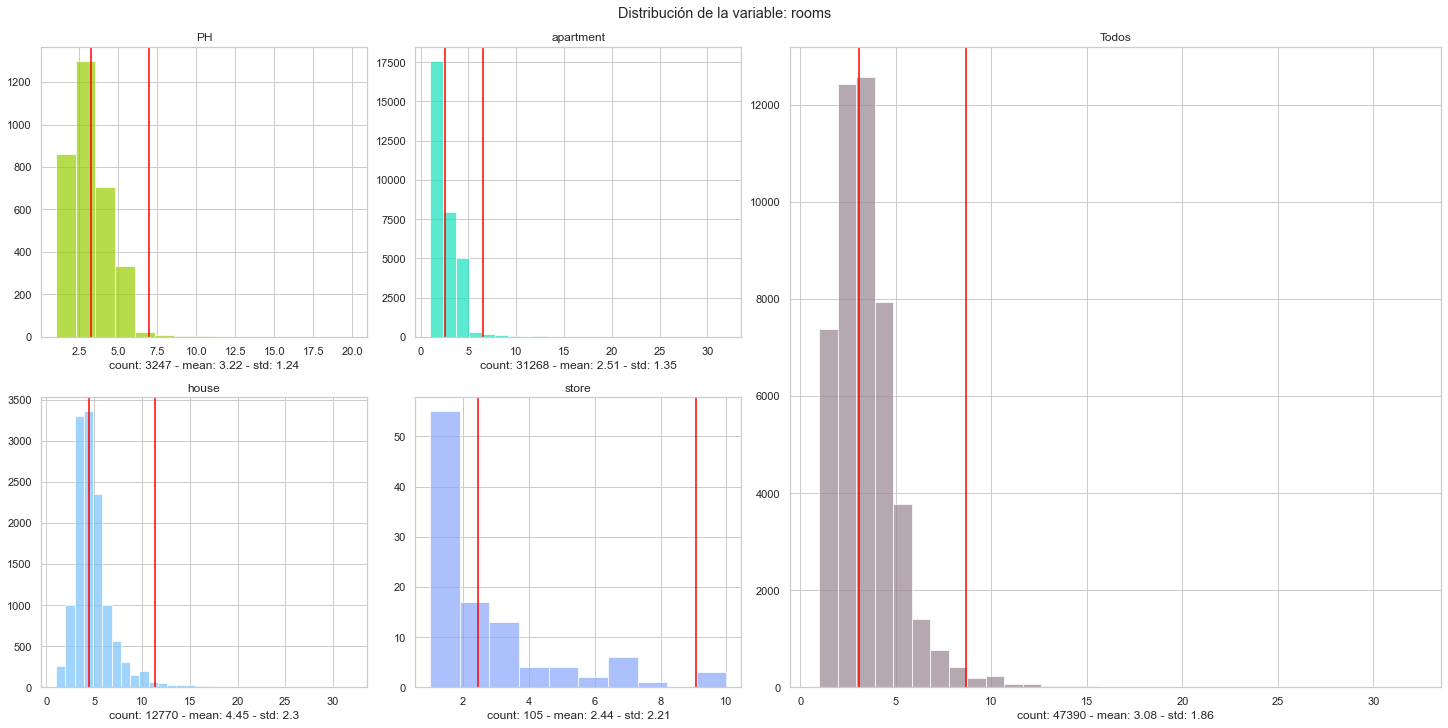

In [48]:
from matplotlib.gridspec import GridSpec

property_types = ['PH', 'apartment', 'house', 'store', 'Dummy']
colors = ["#98ce00","#16e0bd","#78c3fb","#89a6fb","#98838f"]

def format_axes(fig):
    for idx, ax in enumerate(fig.axes):
        if idx == 4:
            subset = o_data['rooms']
            description = subset.describe()
            ax.hist(subset, bins=len(subset.unique()), color=colors[idx], alpha=0.7)
            ax.set_title('Todos')
        else:
            subset = o_data.loc[o_data['property_type'] == property_types[idx]]['rooms']
            description = subset.describe()
            ax.hist(subset, bins=len(subset.unique()), color=colors[idx], alpha=0.7)
            ax.set_title(property_types[idx])
        # axis styling.
        ax.tick_params(labelbottom=True, labelleft=True)            
        ax.set_xlabel(f"count: {round(description.loc['count'])} - mean: {round(description.loc['mean'],2)} - std: {round(description.loc['std'],2)}")
        ax.axvline(x=description.loc['mean'], color='red')
        ax.axvline(x=description.loc['mean'] + (description.loc['std'] * 3), color='red')

fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: rooms")

format_axes(fig)

plt.show()

In [49]:
o_data[['property_type', 'rooms']].groupby('property_type')['rooms'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
PH,3247.0,3.217431,1.239185,1.0,2.0,3.0,4.0,20.0
apartment,31268.0,2.508667,1.349485,1.0,2.0,2.0,3.0,32.0
house,12770.0,4.452388,2.295527,1.0,3.0,4.0,5.0,32.0
store,105.0,2.438095,2.214132,1.0,1.0,1.0,3.0,10.0


In [50]:
o_data.loc[o_data['property_type'] == 'store']['rooms'].describe()

count    105.000000
mean       2.438095
std        2.214132
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       10.000000
Name: rooms, dtype: float64